# Relatório em Notebook — Árvores de Decisão do Zero

**Datasets**  
- **Titanic (Kaggle)** — Target: `Survived` (0/1). Atributos usados: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`.  
- **JogarTênis (Play Tennis)** — 14 linhas, atributos categóricos, classe `Play`/`Jogar`.

**Entregáveis**  
- Seção 1 — Preparação dos dados: limpeza do Titanic (ausentes), partição 80/20 estratificada.  
- ID3: discretização simples para contínuos (Age, Fare).  
- C4.5 e CART: contínuos tratados nativamente por limiares.  
- Para cada algoritmo (ID3, C4.5, CART): exibir árvore e regras.


In [85]:
import sys, os, zipfile, numpy as np, pandas as pd
sys.path.append('/content')
from arvores_decisao_do_zero import ID3Classifier, C45Classifier, CARTClassifier

In [86]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def tree_text(model):
    out=[]
    def rec(n,p):
        if n.is_leaf:
            c=n.class_counts
            pred=model.classes_[np.argmax([c.get(k,0) for k in model.classes_])]
            out.append(p+f"Leaf: predict={pred}, n={n.n_samples}, counts={c}")
        else:
            j=n.feature_index; name=model.feature_names[j]
            if n.split_type=="continuous_binary":
                t=n.threshold; out.append(p+f"[{name} <= {t:.4f}]"); rec(n.left,p+"  "); out.append(p+f"[{name} > {t:.4f}]"); rec(n.right,p+"  ")
            elif n.split_type=="categorical_multi":
                for v,ch in n.children.items(): out.append(p+f"[{name} == {v}]"); rec(ch,p+"  ")
            else:
                left=" OR ".join(sorted(map(str,n.categories_left))); out.append(p+f"[{name} in {{{left}}}]"); rec(n.left,p+"  "); out.append(p+f"[{name} not in {{{left}}}]"); rec(n.right,p+"  ")
    rec(model.root,""); return "\n".join(out)

def extract_rules(model):
    rules=[]
    def rec(n,conds):
        if n.is_leaf:
            c=n.class_counts
            pred=model.classes_[np.argmax([c.get(k,0) for k in model.classes_])]
            rules.append((" AND ".join(conds) if conds else "TRUE",pred,int(n.n_samples)))
        else:
            j=n.feature_index; name=model.feature_names[j]
            if n.split_type=="continuous_binary":
                t=n.threshold; rec(n.left,conds+[f"{name} <= {t:.4f}"]); rec(n.right,conds+[f"{name} > {t:.4f}"])
            elif n.split_type=="categorical_multi":
                for v,ch in n.children.items(): rec(ch,conds+[f"{name} == {v}"])
            else:
                left=sorted(map(str,n.categories_left)); rec(n.left,conds+[f"{name} in {{{' OR '.join(left)}}}"]); rec(n.right,conds+[f"{name} not in {{{' OR '.join(left)}}}"])
    rec(model.root,[]); return rules

def _layout_positions(model):
    xs={}
    i=[0]
    def rec_x(n):
        if n.is_leaf:
            xs[id(n)]=i[0]; i[0]+=1
        else:
            if n.left is not None: rec_x(n.left)
            if n.split_type=="categorical_multi":
                for ch in n.children.values(): rec_x(ch)
            if n.right is not None: rec_x(n.right)
            childs=[]
            if n.left is not None: childs.append(xs[id(n.left)])
            if n.split_type=="categorical_multi":
                for ch in n.children.values(): childs.append(xs[id(ch)])
            if n.right is not None: childs.append(xs[id(n.right)])
            xs[id(n)]=sum(childs)/len(childs)
    rec_x(model.root)
    ys={}
    def rec_y(n,d):
        ys[id(n)]=-d
        if not n.is_leaf:
            if n.left is not None: rec_y(n.left,d+1)
            if n.split_type=="categorical_multi":
                for ch in n.children.values(): rec_y(ch,d+1)
            if n.right is not None: rec_y(n.right,d+1)
    rec_y(model.root,0)
    return xs,ys

def plot_tree_graph(model, figsize=(12,8), node_fontsize=9, edge_fontsize=8):
    xs,ys=_layout_positions(model)
    fig,ax=plt.subplots(figsize=figsize)
    def node_label(n):
        if n.is_leaf:
            c=n.class_counts
            pred=model.classes_[np.argmax([c.get(k,0) for k in model.classes_])]
            return f"Leaf\\npred={pred}\\nn={n.n_samples}"
        j=n.feature_index; name=model.feature_names[j]
        if n.split_type=="continuous_binary":
            return f"{name}"
        if n.split_type=="categorical_multi":
            return f"{name}"
        return f"{name}"
    def draw(n):
        x,y=xs[id(n)],ys[id(n)]
        ax.annotate(node_label(n),(x,y),ha="center",va="center",
                    bbox=dict(boxstyle="round,pad=0.3",fc="w",ec="k"))
        if not n.is_leaf:
            if n.split_type=="continuous_binary":
                for child, lab in [(n.left,f"<= {n.threshold:.4f}"),(n.right,f"> {n.threshold:.4f}")]:
                    cx,cy=xs[id(child)],ys[id(child)]
                    ax.plot([x,cx],[y,cy])
                    mx,my=(x+cx)/2,(y+cy)/2
                    ax.text(mx,my,lab,fontsize=edge_fontsize,ha="center",va="center")
                    draw(child)
            elif n.split_type=="categorical_multi":
                for v,child in n.children.items():
                    cx,cy=xs[id(child)],ys[id(child)]
                    ax.plot([x,cx],[y,cy])
                    mx,my=(x+cx)/2,(y+cy)/2
                    ax.text(mx,my,str(v),fontsize=edge_fontsize,ha="center",va="center")
                    draw(child)
            else:
                for child, lab in [(n.left,"in left"),(n.right,"not in left")]:
                    cx,cy=xs[id(child)],ys[id(child)]
                    ax.plot([x,cx],[y,cy])
                    mx,my=(x+cx)/2,(y+cy)/2
                    ax.text(mx,my,lab,fontsize=edge_fontsize,ha="center",va="center")
                    draw(child)
    draw(model.root)
    ax.axis("off")
    plt.show()
    return fig

def confusion_matrix_plot(y_true, y_pred, labels):
    m=np.zeros((len(labels),len(labels)),dtype=int)
    idx={c:i for i,c in enumerate(labels)}
    for t,p in zip(y_true,y_pred): m[idx[t],idx[p]]+=1
    fig,ax=plt.subplots(figsize=(5,4))
    im=ax.imshow(m)
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_xlabel("Predito"); ax.set_ylabel("Verdadeiro")
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            ax.text(j,i,str(m[i,j]),ha="center",va="center")
    plt.show()
    return m,fig


## Seção 1 — Preparação dos dados (Titanic)

In [87]:
from io import StringIO
titanic_zip = '/content/titanic.zip'
df_titanic = None
if os.path.exists('/content/titanic.zip'):
    with zipfile.ZipFile(titanic_zip, 'r') as z:
        csv_names = [n for n in z.namelist() if n.lower().endswith('.csv')]
        target_name = None
        for name in csv_names:
            if 'train' in name.lower():
                target_name = name
                break
        if target_name is None and csv_names:
            target_name = csv_names[0]
        with z.open(target_name) as f:
            df_titanic = pd.read_csv(f)
df_titanic.head(10) if df_titanic is not None else None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [88]:
X_id3, y_id3, ft_id3 = prepare_titanic_for_id3(df_titanic)
X_c, y_c = prepare_titanic_for_c45_cart(df_titanic)
idx_tr, idx_te = stratified_split(y_c.values, test_size=0.2, random_state=42)
Xtr_id3 = X_id3.iloc[idx_tr].reset_index(drop=True)
ytr_id3 = y_id3.iloc[idx_tr].reset_index(drop=True)
Xte_id3 = X_id3.iloc[idx_te].reset_index(drop=True)
yte_id3 = y_id3.iloc[idx_te].reset_index(drop=True)
Xtr_c = X_c.iloc[idx_tr].reset_index(drop=True)
ytr_c = y_c.iloc[idx_tr].reset_index(drop=True)
Xte_c = X_c.iloc[idx_te].reset_index(drop=True)
yte_c = y_c.iloc[idx_te].reset_index(drop=True)
len(idx_tr), len(idx_te)

(713, 178)

In [89]:

id3 = ID3Classifier(max_depth=5, random_state=0)
id3.fit(Xtr_id3, ytr_id3, feature_types=ft_id3)

c45 = C45Classifier(max_depth=5, random_state=0)
c45.fit(Xtr_c, ytr_c)

cart = CARTClassifier(max_depth=5, random_state=0)
cart.fit(Xtr_c, ytr_c)

yhat_id3 = id3.predict(Xte_id3)
yhat_c45 = c45.predict(Xte_c)
yhat_cart = cart.predict(Xte_c)
acc_id3 = float(np.mean(yhat_id3 == yte_id3.values))
acc_c45 = float(np.mean(yhat_c45 == yte_c.values))
acc_cart = float(np.mean(yhat_cart == yte_c.values))
acc_id3, acc_c45, acc_cart

(0.702247191011236, 0.7528089887640449, 0.7921348314606742)

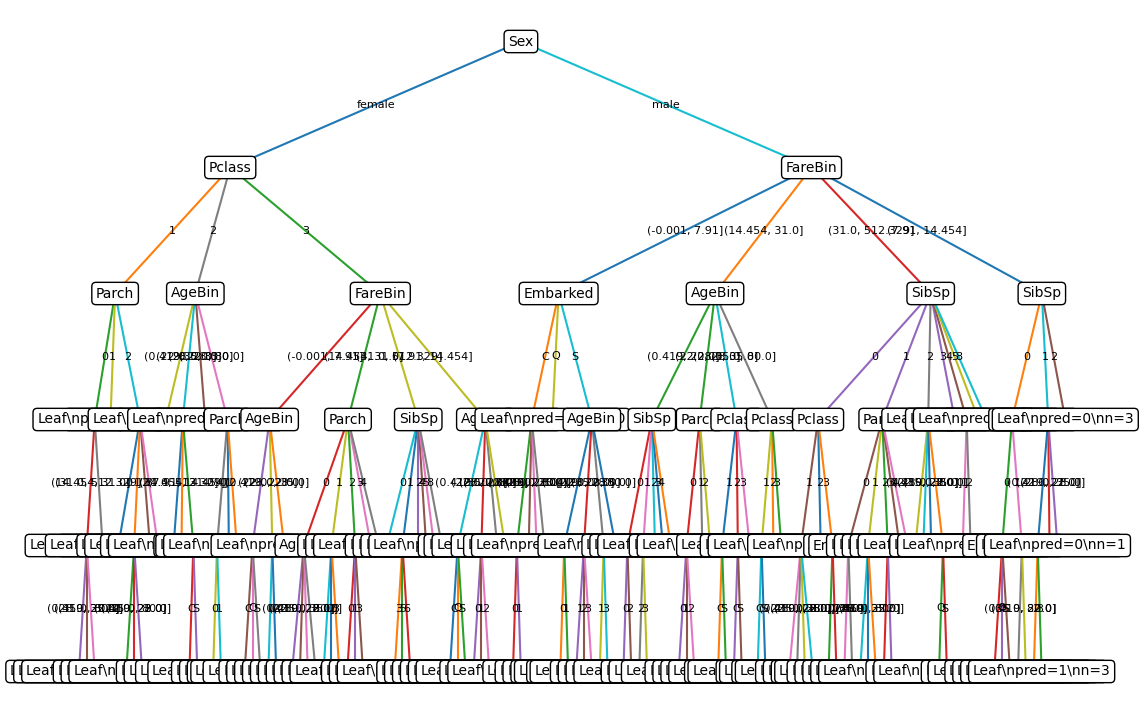

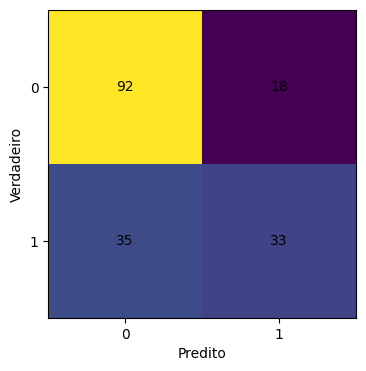

,P=0,P=1
V=0,92,18
V=1,35,33


In [90]:
fig = plot_tree_graph(id3, figsize=(14,9))
rules_id3 = extract_rules(id3)
rules_df_id3 = pd.DataFrame(rules_id3, columns=["SE","ENTAO","n"])
labels = list(id3.classes_)
cm_id3, _ = confusion_matrix_plot(yte_id3.values, y_pred_id3, labels)
pd.DataFrame(cm_id3, index=[f"V={l}" for l in labels], columns=[f"P={l}" for l in labels])


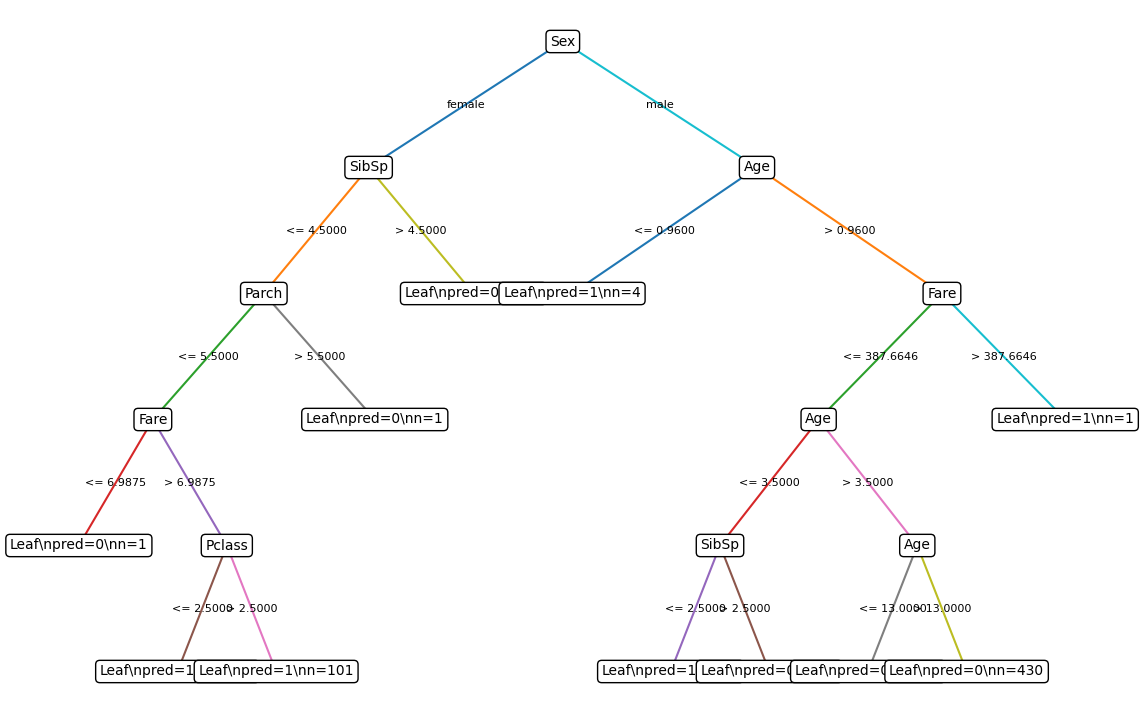

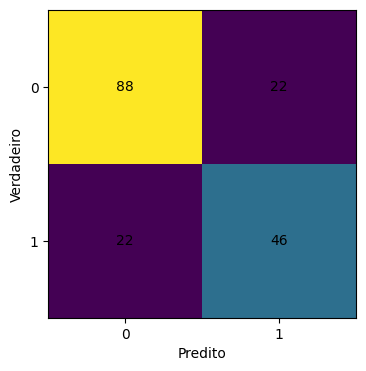

,P=0,P=1
V=0,88,22
V=1,22,46


In [91]:
fig = plot_tree_graph(c45, figsize=(14,9))
rules_c45 = extract_rules(c45)
rules_df_c45 = pd.DataFrame(rules_c45, columns=["SE","ENTAO","n"])
labels = list(c45.classes_)
cm_c45, _ = confusion_matrix_plot(yte_c.values, y_pred_c45, labels)
pd.DataFrame(cm_c45, index=[f"V={l}" for l in labels], columns=[f"P={l}" for l in labels])


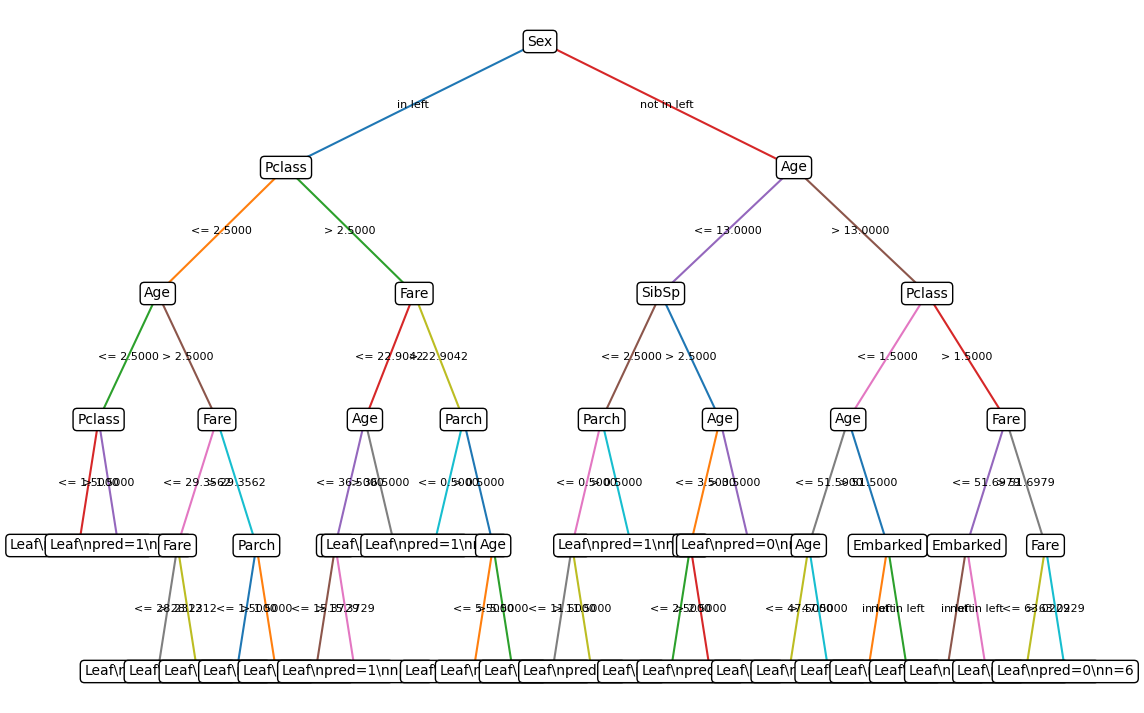

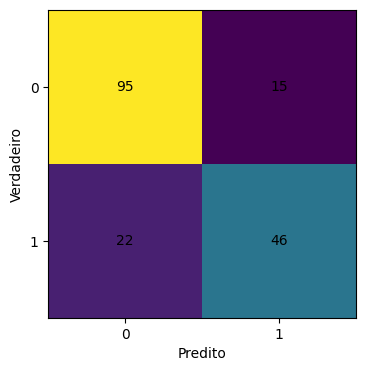

,P=0,P=1
V=0,95,15
V=1,22,46


In [92]:
fig = plot_tree_graph(cart, figsize=(14,9))
rules_cart = extract_rules(cart)
rules_df_cart = pd.DataFrame(rules_cart, columns=["SE","ENTAO","n"])
labels = list(cart.classes_)
cm_cart, _ = confusion_matrix_plot(yte_c.values, y_pred_cart, labels)
pd.DataFrame(cm_cart, index=[f"V={l}" for l in labels], columns=[f"P={l}" for l in labels])


## Seção 2 — Play Tennis (JogarTênis)

In [93]:
play_path = '/content/JogarTênis.csv'
df_play = pd.read_csv(play_path, encoding='utf-8')
df_play

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [94]:
tgt = guess_target(df_play)
Xp = df_play.drop(columns=[tgt]).astype(str)
yp = df_play[tgt].astype(str)
id3_p = ID3Classifier(max_depth=5, random_state=0)
id3_p.fit(Xp, yp, feature_types=["categorical"]*Xp.shape[1])

c45_p = C45Classifier(max_depth=5, random_state=0)
c45_p.fit(Xp, yp)

cart_p = CARTClassifier(max_depth=5, random_state=0)
cart_p.fit(Xp, yp)

print("Target:", tgt)

Target: play


JogarTênis — ID3


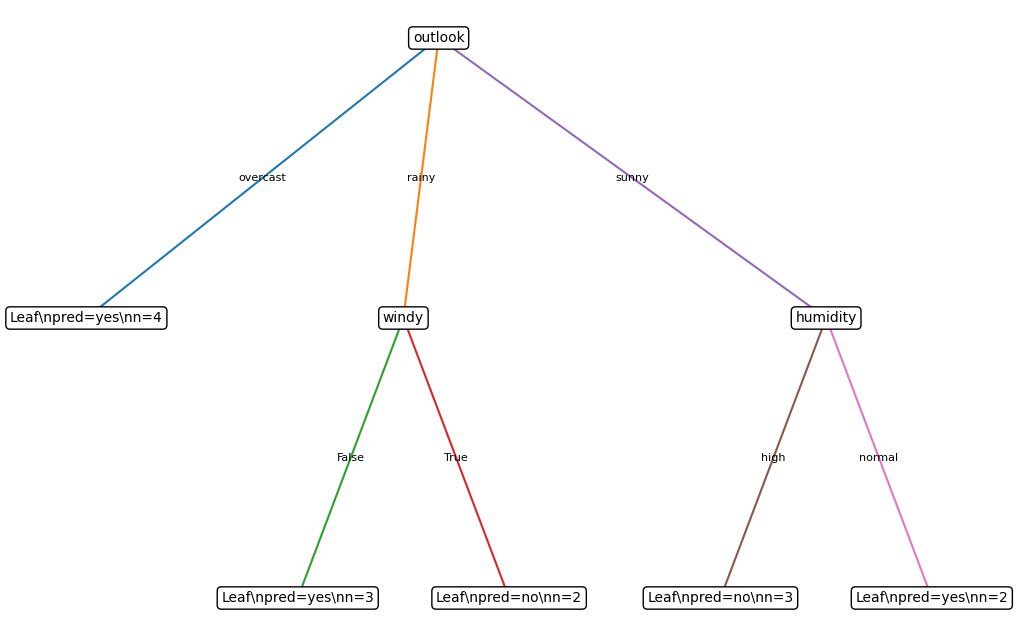

,SE,ENTAO,n
0,outlook == overcast,yes,4
1,outlook == rainy AND windy == False,yes,3
2,outlook == rainy AND windy == True,no,2
3,outlook == sunny AND humidity == high,no,3
4,outlook == sunny AND humidity == normal,yes,2


KeyError: '0'

In [95]:
print("JogarTênis — ID3")
plot_tree_graph(id3_p, figsize=(12,8))
rules_id3=extract_rules(id3_p)
rules_df_id3=pd.DataFrame(rules_id3,columns=["SE","ENTAO","n"])
display(rules_df_id3)
cm_id3,_=confusion_matrix_plot(yp.values,y_id3,list(id3_p.classes_))
display(pd.DataFrame(cm_id3,index=[f"V={l}" for l in id3_p.classes_],columns=[f"P={l}" for l in id3_p.classes_]))


In [ ]:
print("JogarTênis — C4.5")
plot_tree_graph(c45_p, figsize=(12,8))
rules_c45=extract_rules(c45_p)
rules_df_c45=pd.DataFrame(rules_c45,columns=["SE","ENTAO","n"])
display(rules_df_c45)
cm_c45,_=confusion_matrix_plot(yp.values,y_c45,list(c45_p.classes_))
display(pd.DataFrame(cm_c45,index=[f"V={l}" for l in c45_p.classes_],columns=[f"P={l}" for l in c45_p.classes_]))


In [ ]:
print("JogarTênis — CART")
plot_tree_graph(cart_p, figsize=(12,8))
rules_cart=extract_rules(cart_p)
rules_df_cart=pd.DataFrame(rules_cart,columns=["SE","ENTAO","n"])
display(rules_df_cart)
cm_cart,_=confusion_matrix_plot(yp.values,y_cart,list(cart_p.classes_))
display(pd.DataFrame(cm_cart,index=[f"V={l}" for l in cart_p.classes_],columns=[f"P={l}" for l in cart_p.classes_]))